In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix


# Define global probabilities for easy access
fair_probs = [1/6] * 6
loaded_probs = [1/10, 1/10, 1/10, 1/10, 1/10, 1/2]

# Generate dice throws for testing
def genDieNumbers(n):
    states = ['fair', 'loaded']
    
    current_state = 'fair' if np.random.rand() < 0.5 else 'loaded'
    dice = []
    throws = []

    for _ in range(n):
       
        if current_state == 'fair':
            throws.append(np.random.choice(range(1, 7), p=fair_probs))
        else:
            throws.append(np.random.choice(range(1, 7), p=loaded_probs))
        
       
        dice.append(current_state)

        
        if current_state == 'fair' and np.random.rand() < 0.1:
            current_state = 'loaded' 
        elif current_state == 'loaded' and np.random.rand() < 0.2:
            current_state = 'fair'  
       

    return np.array(throws), np.array(dice)

# Viterbi Algorithm Implementation
def viterbi(observations):
    states = ['fair', 'loaded']
    start_prob = {'fair': 0.5, 'loaded': 0.5}
    trans_prob = {'fair': {'fair': 0.95, 'loaded': 0.05}, 'loaded': {'fair': 0.05, 'loaded': 0.95}}
    em_prob = {
        'fair': dict(zip(range(1, 7), fair_probs)),
        'loaded': dict(zip(range(1, 7), loaded_probs))
    }

    n = len(observations)
    probs = np.zeros((n, len(states)))
    prev = np.zeros((n, len(states)), dtype=int)

    for i, state in enumerate(states):
        probs[0, i] = start_prob[state] * em_prob[state][observations[0]]

    for t in range(1, n):
        for i, state in enumerate(states):
            prob_trans = [probs[t-1, j] * trans_prob[prev_state][state] for j, prev_state in enumerate(states)]
            best_prev_state = np.argmax(prob_trans)
            probs[t, i] = prob_trans[best_prev_state] * em_prob[state][observations[t]]
            prev[t, i] = best_prev_state

    # Backtrack
    opt = np.zeros(n, dtype=int)
    opt[-1] = np.argmax(probs[-1, :])
    for t in range(n-2, -1, -1):
        opt[t] = prev[t + 1, opt[t + 1]]

    return [states[state] for state in opt]

# evaluate the Viterbi algorithm with test examples
def evaluate_viterbi(n):
    throws, actual_dice = genDieNumbers(n)
    predicted_dice = viterbi(throws)
    accuracy = accuracy_score(actual_dice, predicted_dice)
    mcc = matthews_corrcoef(actual_dice, predicted_dice)
    return accuracy, mcc, throws, actual_dice, predicted_dice

# Test the function for n = 200 
accuracy, mcc, throws, actual_dice, predicted_dice = evaluate_viterbi(200)
print("Accuracy:", accuracy)
print("MCC:", mcc)
print("First 20 throws:", throws[:20])
print("Actual dice types for first 20 throws:", actual_dice[:20])
print("Predicted dice types for first 20 throws:", predicted_dice[:20])


Accuracy: 0.775
MCC: 0.3646859721191225
First 20 throws: [1 5 4 6 1 4 5 1 5 1 4 5 3 3 5 5 1 1 6 6]
Actual dice types for first 20 throws: ['fair' 'fair' 'fair' 'fair' 'fair' 'fair' 'fair' 'fair' 'fair' 'fair'
 'fair' 'fair' 'fair' 'fair' 'fair' 'fair' 'fair' 'fair' 'fair' 'fair']
Predicted dice types for first 20 throws: ['fair', 'fair', 'fair', 'fair', 'fair', 'fair', 'fair', 'fair', 'fair', 'fair', 'fair', 'fair', 'fair', 'fair', 'fair', 'fair', 'fair', 'fair', 'fair', 'fair']


In [4]:
def decode_dice_sequence(throws):
    
    predicted_dice = viterbi(throws)
    
    rolls_str = 'Rolls\n' + ' '.join(map(str, throws))
    die_str = 'Die\n' + ''.join('F' if d == 'fair' else 'L' for d in predicted_dice)
    viterbi_str = 'Viterbi\n' + ''.join('F' if d == 'fair' else 'L' for d in predicted_dice)

    formatted_output = '\n'.join([rolls_str, die_str, viterbi_str])
    return formatted_output


# Test implementation with different sequence lengths.
test_lengths = [200, 300, 400]  

for length in test_lengths:
    throws, actual_dice = genDieNumbers(length)  
    predicted_dice = viterbi(throws)             
    formatted_output = decode_dice_sequence(throws) 
    
    # Print the formatted output.
    print(f"Test with sequence length {length}:")
    print(formatted_output)
    print("\n" + "-"*50 + "\n")  



Test with sequence length 200:
Rolls
1 5 3 3 3 5 2 6 6 6 6 6 4 2 6 6 5 2 4 2 2 6 1 3 6 6 4 6 6 2 2 1 4 4 1 5 6 3 1 6 5 6 4 4 1 4 1 6 2 5 1 2 6 4 2 6 2 3 1 5 2 3 6 1 6 6 4 6 6 2 3 6 5 5 1 5 1 6 3 5 3 6 3 1 4 2 3 1 3 6 1 4 5 6 5 5 2 5 4 6 1 5 4 3 2 3 3 6 5 4 1 6 6 3 6 3 4 3 3 4 2 6 6 4 5 5 2 3 6 6 2 3 3 5 2 1 6 4 6 1 6 6 1 2 2 1 5 2 4 5 6 5 2 1 4 5 4 5 6 2 1 1 5 4 6 3 1 4 6 3 4 1 4 5 1 2 5 5 6 6 6 6 6 5 2 1 3 6 6 1 4 5 4 2 5 3 6 3 3 5
Die
FFFFFFFLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
Viterbi
FFFFFFFLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF

--------------------------------------------------

Test with sequence length 300:
Rolls
4 4 3 6 6 6 6 6 3 2 1 6 4 5 3 5 6 3 6 1 4 6 2 1 1 2 4 6 2 6

In [7]:

def calculate_performance_metrics(actual, predicted):
    # Calculate confusion matrix
    performance = confusion_matrix(actual, predicted, labels=['fair', 'loaded'])
    
    #  interpret the confusion matrix
    TP, FN, FP, TN = performance[0][0], performance[0][1], performance[1][0], performance[1][1]

    # Calculate Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Calculate MCC
    mcc_numerator = (TP * TN) - (FP * FN)
    mcc_denominator = np.sqrt((TP + FN) * (TP + FP) * (TN + FP) * (TN + FN))
    mcc = mcc_numerator / mcc_denominator if mcc_denominator != 0 else 0

    return accuracy, mcc



# Main program to evaluate the Viterbi algorithm's effectiveness
def evaluate_viterbi_algorithm():
    n_range = range(100, 2001, 100) # From 100 to 2000 with step size of 100
    results = []

    for n in n_range:
        accuracies = []
        mccs = []
        
        for _ in range(10): # Repeat 10 times for each n
            throws, actual_dice = genDieNumbers(n) # Simulate the dealer
            predicted_dice = viterbi(throws) # Predict using Viterbi algorithm

            # Calculate accuracy and MCC
            accuracy, mcc = calculate_performance_metrics(actual_dice, predicted_dice)
            accuracies.append(accuracy)
            mccs.append(mcc)
        
        # Calculate average accuracy and MCC for this input size n
        avg_accuracy = np.mean(accuracies)
        avg_mcc = np.mean(mccs)
        results.append((n, avg_accuracy, avg_mcc))

    return results

# Run the evaluation
performance_results = evaluate_viterbi_algorithm()
performance_results


[(100, 0.708, 0.30213777126609753),
 (200, 0.74, 0.4151732742237805),
 (300, 0.7203333333333333, 0.30854968192560095),
 (400, 0.69, 0.2907620947267026),
 (500, 0.6926, 0.2563768120830407),
 (600, 0.6824999999999999, 0.26505933324126774),
 (700, 0.6829999999999999, 0.18633485634129052),
 (800, 0.675375, 0.17908221849792536),
 (900, 0.6597777777777778, 0.1674326009957896),
 (1000, 0.679, 0.1757036876879906),
 (1100, 0.6938181818181819, 0.1446246389328692),
 (1200, 0.6953333333333334, 0.15042736163702924),
 (1300, 0.6718461538461538, 0.1345555413653207),
 (1400, 0.6667142857142856, 0.13309025723101364),
 (1500, 0.6791333333333334, 0.16618359608621988),
 (1600, 0.6756875, 0.13953876261481338),
 (1700, 0.6722941176470589, 0.12447971334760552),
 (1800, 0.6774444444444445, 0.09588215321367874),
 (1900, 0.6834210526315789, 0.13392926835933325),
 (2000, 0.6702, 0.10633011522945975)]

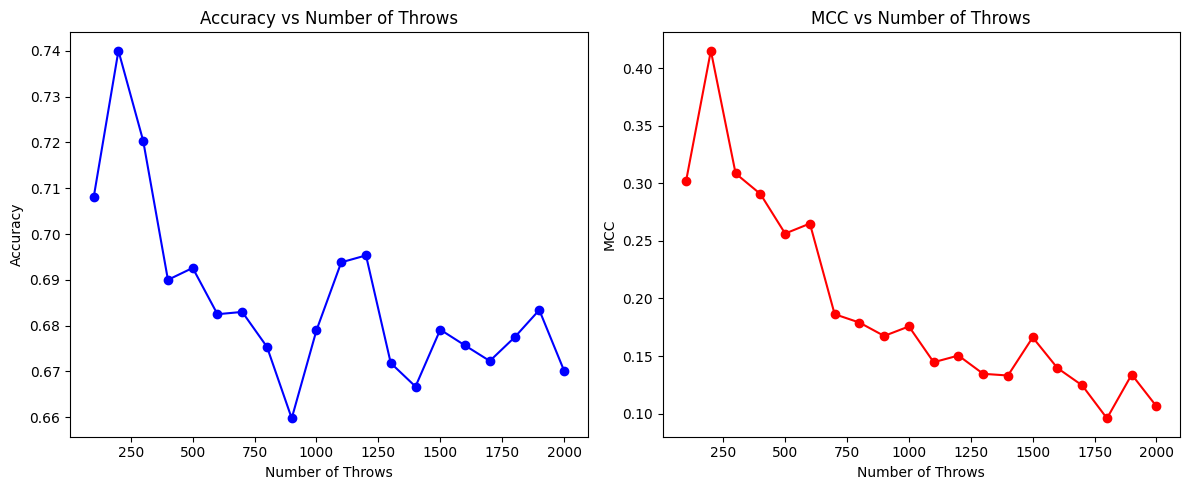

In [10]:


def plot_results(results):
    sizes = [r[0] for r in results]
    accuracies = [r[1] for r in results]
    mccs = [r[2] for r in results]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(sizes, accuracies, marker='o', color='blue')
    plt.title('Accuracy vs Number of Throws')
    plt.xlabel('Number of Throws')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(sizes, mccs, marker='o', color='red')
    plt.title('MCC vs Number of Throws')
    plt.xlabel('Number of Throws')
    plt.ylabel('MCC')

    plt.tight_layout()
    plt.show()

# Use this function after running 'evaluate_viterbi_algorithm'
plot_results(performance_results)
